In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ISIC 2017 Segmentation

In [ ]:
cd /content/drive/MyDrive/SharedFilesHere/Codes_ADL_Assignment/Seg_UKAN

/content/drive/MyDrive/SharedFilesHere/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
cd /content/drive/MyDrive/Codes_ADL_Assignment/

/content/drive/MyDrive/Codes_ADL_Assignment


In [ ]:
cd Seg_UKAN/

/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
ls

archs.py         evaluate.py            metrics.py               __pycache__/      val.py
BestModels/      kan.py                 moveValidationFetus.sh   requirements.txt
config.py        LICENSE                noTrain.py               scripts.sh
dataset.py       losses.py              outputs/                 train.py
environment.yml  lumbarSpineDataset.py  predict_single_image.py  utils.py


In [ ]:
cd /content/drive/MyDrive/Datasets/ISIC/

/content/drive/MyDrive/Datasets/ISIC


In [ ]:
ls

ISIC-2017_Test_v2_Data.zip                ISIC-2017_Training_Part2_GroundTruth.zip
ISIC-2017_Test_v2_Part1_GroundTruth.zip   ISIC-2017_Training_Part3_GroundTruth.csv
ISIC-2017_Test_v2_Part2_GroundTruth.zip   ISIC-2017_Validation_Data/
ISIC-2017_Test_v2_Part3_GroundTruth.csv   ISIC-2017_Validation_Data.zip
ISIC-2017_Training_Data/                  ISIC-2017_Validation_Part1_GroundTruth/
ISIC-2017_Training_Data.zip               ISIC-2017_Validation_Part1_GroundTruth.zip
ISIC-2017_Training_Part1_GroundTruth/     ISIC-2017_Validation_Part2_GroundTruth.zip
ISIC-2017_Training_Part1_GroundTruth.zip  ISIC-2017_Validation_Part3_GroundTruth.csv


In [ ]:
# !unzip ISIC-2017_Validation_Data.zip

In [ ]:
# !unzip ISIC-2017_Validation_Part1_GroundTruth.zip

In [ ]:
cd /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/

/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
# !ls /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Training_Part1_GroundTruth
!ls /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Validation_Part1_GroundTruth

ISIC_0001769_segmentation.png  ISIC_0012417_segmentation.png  ISIC_0014211_segmentation.png
ISIC_0001852_segmentation.png  ISIC_0012434_segmentation.png  ISIC_0014212_segmentation.png
ISIC_0001871_segmentation.png  ISIC_0012492_segmentation.png  ISIC_0014217_segmentation.png
ISIC_0003462_segmentation.png  ISIC_0012513_segmentation.png  ISIC_0014302_segmentation.png
ISIC_0003539_segmentation.png  ISIC_0012538_segmentation.png  ISIC_0014310_segmentation.png
ISIC_0003582_segmentation.png  ISIC_0012547_segmentation.png  ISIC_0014382_segmentation.png
ISIC_0003657_segmentation.png  ISIC_0012660_segmentation.png  ISIC_0014428_segmentation.png
ISIC_0003805_segmentation.png  ISIC_0012684_segmentation.png  ISIC_0014558_segmentation.png
ISIC_0004337_segmentation.png  ISIC_0012720_segmentation.png  ISIC_0014568_segmentation.png
ISIC_0006651_segmentation.png  ISIC_0012746_segmentation.png  ISIC_0014572_segmentation.png
ISIC_0006671_segmentation.png  ISIC_0012876_segmentation.png  ISIC_0014597_segme

In [4]:
cd /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN

/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
pwd

'/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN'

In [ ]:
!python dataset.py

Found 2000 valid image-mask pairs


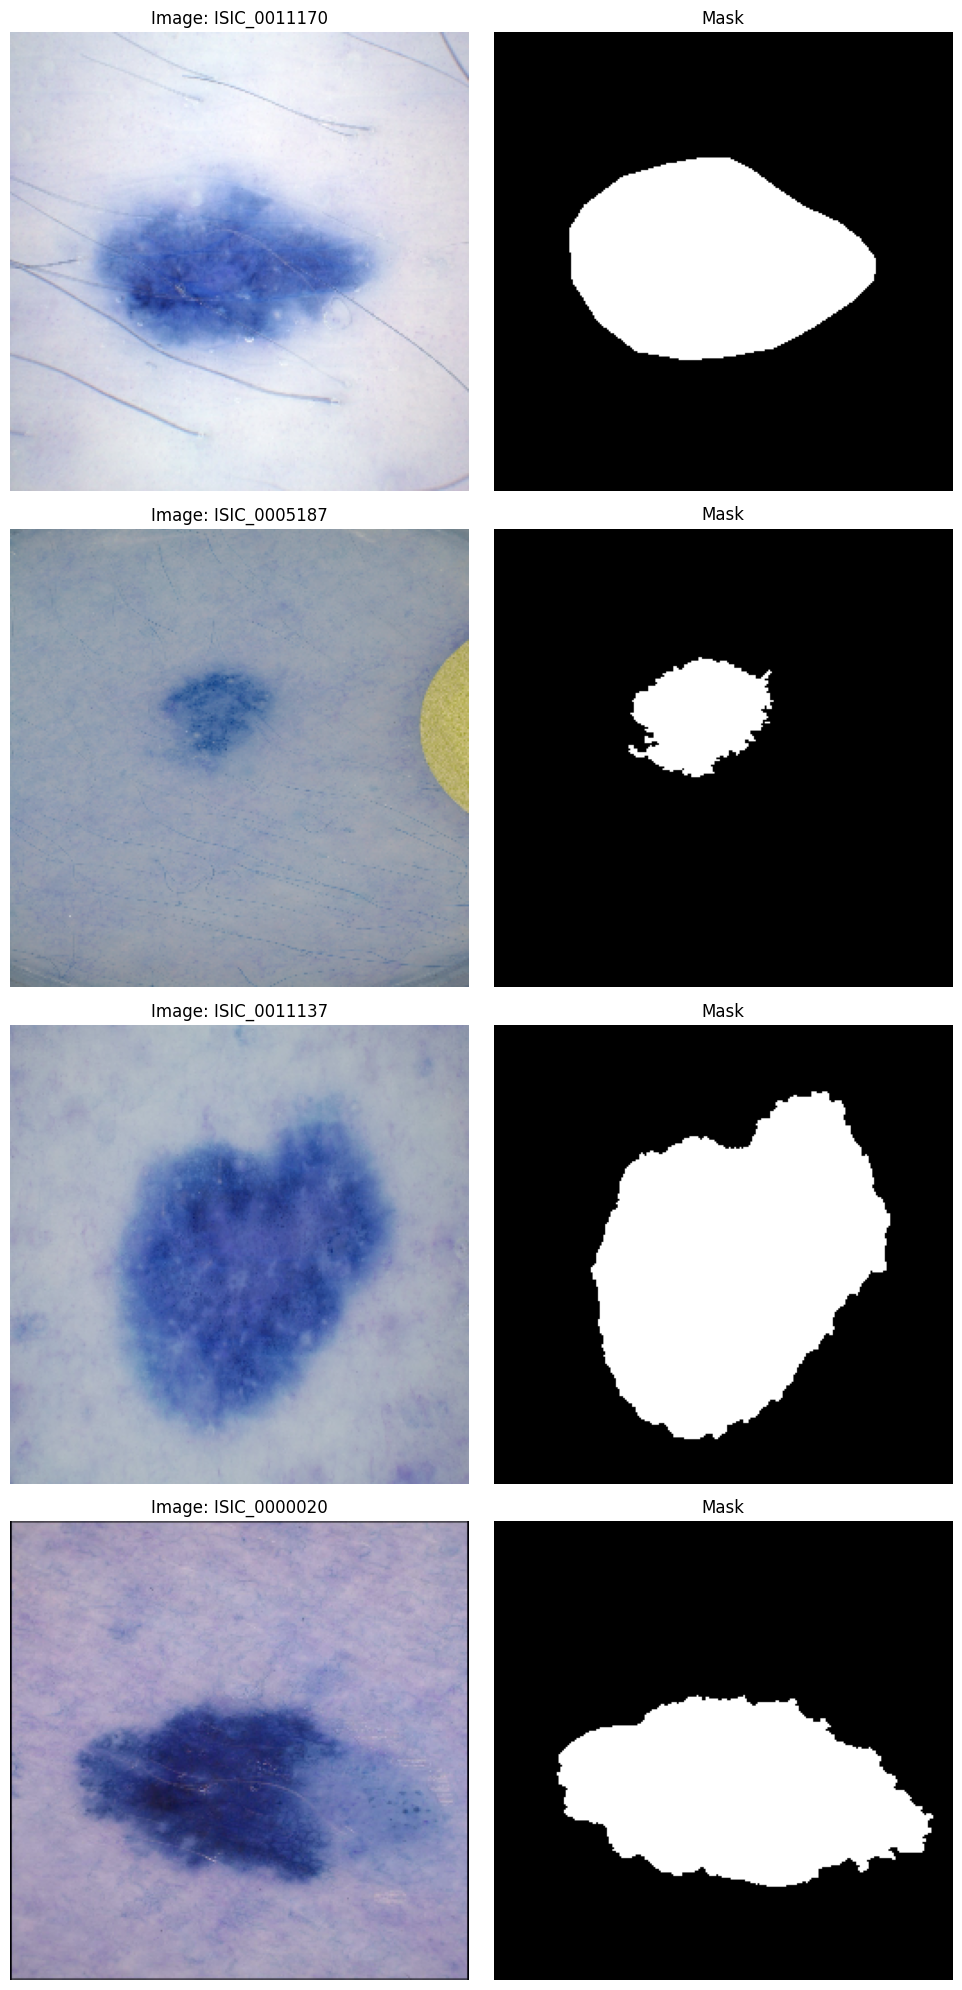

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from torch.utils.data import DataLoader
import albumentations as A
from dataset import Dataset
from glob import glob

def visualize_dataset(data_dir, dataset_name, img_ext, mask_ext, mask_suffix):
    """Universal visualization function for both datasets"""
    # Configure paths based on dataset
    if dataset_name == 'ISIC':
        img_dir = os.path.join(data_dir, 'ISIC-2017_Training_Data')
        mask_dir = os.path.join(data_dir, 'ISIC-2017_Training_Part1_GroundTruth')
    elif dataset_name == 'Fetus_Head':
        img_dir = os.path.join(data_dir, 'training_set')
        mask_dir = os.path.join(data_dir, 'training_set')
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    # Get matched image-mask pairs
    img_files = sorted([f for f in glob(os.path.join(img_dir, '*' + img_ext))
                       if not f.endswith(mask_ext)])
    img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_files]

    mask_files = sorted(glob(os.path.join(mask_dir, '*' + mask_ext)))
    mask_ids = [os.path.splitext(os.path.basename(p))[0].replace(mask_suffix, '') for p in mask_files]

    # Filter to ensure 1:1 mapping
    valid_pairs = [(i, m) for i, m in zip(img_ids, mask_ids)
                  if os.path.exists(os.path.join(mask_dir, f"{m}{mask_ext}"))]
    img_ids, mask_ids = zip(*valid_pairs) if valid_pairs else ([], [])

    print(f"Found {len(img_ids)} valid image-mask pairs")

    transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ])

    # Create dataset and loader
    dataset = Dataset(
        img_ids=list(img_ids),
        mask_ids=list(mask_ids),
        img_dir=img_dir,
        mask_dir=mask_dir,
        img_ext=img_ext,
        mask_ext=mask_ext,
        num_classes=1,
        transform=transform
    )

    data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

    # Visualize
    images, masks, metadatas = next(iter(data_loader))

    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    for i in range(4):
        image = images[i].numpy().transpose(1, 2, 0)
        mask = masks[i].numpy().transpose(1, 2, 0).squeeze()

        axes[i,0].imshow(image)
        axes[i,0].set_title(f'Image: {metadatas["img_id"][i]}')
        axes[i,0].axis('off')

        axes[i,1].imshow(mask, cmap='gray')
        axes[i,1].set_title('Mask')
        axes[i,1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for ISIC:
visualize_dataset(
    data_dir='/content/drive/MyDrive/Datasets/ISIC',
    dataset_name='ISIC',
    img_ext='.jpg',
    mask_ext='_segmentation.png',
    mask_suffix='_segmentation'
)

In [2]:
!pip install medpy
!pip install tensorboardX
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.8 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=e8d67da5bcdafe1bb2dbf7fe4a507510afa0fdc85645d78183b92c525718f242
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
!python train.py --dataset ISIC --data_dir '/content/drive/MyDrive/Datasets/ISIC' --name isic_ukan_upgraded --epochs 30 -b 8 --upgrade

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO: Using UPGRADED architectures from archs_upgraded.py
Using device : cuda
--------------------
name: isic_ukan_upgraded
epochs: 30
batch_size: 8
dataseed: 2981
arch: UKAN
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 256
input_h: 256
input_list: [128, 160, 256]
upgrade: True
loss: BCEDiceLoss
dataset: ISIC
data_dir: /content/drive/MyDrive/Datasets/ISIC
output_dir: /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
kan_lr: 0.01
kan_weight_decay: 0.0001
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
cfg: None
num_workers: 4
no_k

In [ ]:
!python train.py --dataset ISIC --data_dir '/content/drive/MyDrive/Datasets/ISIC' --name isic_ukan --epochs 30 -b 8

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using device : cpu
--------------------
name: two
epochs: 200
batch_size: 8
dataseed: 2981
arch: UKAN
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 256
input_h: 256
input_list: [128, 160, 256]
loss: BCEDiceLoss
dataset: ISIC
data_dir: /content/drive/MyDrive/SharedFilesHere/Datasets/ISIC
output_dir: /content/drive/MyDrive/SharedFilesHere/Codes_ADL_Assignment/Seg_UKAN/outputs
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
kan_lr: 0.01
kan_weight_decay: 0.0001
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
cfg: None
num_workers: 4
no_kan: False
--------------------
Training image paths: ['

In [ ]:
ls

archs.py   dataset.py       kan.py   losses.py   __pycache__/      scripts.sh  utils.py
config.py  environment.yml  LICENSE  metrics.py  requirements.txt  train.py    val.py


In [ ]:
!mv /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part1_GroundTruth/* /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Validation_Part1_GroundTruth/

mv: cannot stat '/content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part1_GroundTruth/*': No such file or directory


In [ ]:
!ls /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Training_Part1_GroundTruth/ISIC_0013400*

/content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Training_Part1_GroundTruth/ISIC_0013400_segmentation.png


In [ ]:
# !zip -r Seg_UKAN.zip Seg_UKAN/

  adding: Seg_UKAN/ (stored 0%)
  adding: Seg_UKAN/__pycache__/ (stored 0%)
  adding: Seg_UKAN/__pycache__/dataset.cpython-311.pyc (deflated 46%)
  adding: Seg_UKAN/val.py (deflated 65%)
  adding: Seg_UKAN/scripts.sh (deflated 77%)
  adding: Seg_UKAN/losses.py (deflated 59%)
  adding: Seg_UKAN/train.py (deflated 75%)
  adding: Seg_UKAN/kan.py (deflated 77%)
  adding: Seg_UKAN/LICENSE (deflated 41%)
  adding: Seg_UKAN/config.py (deflated 66%)
  adding: Seg_UKAN/.zip (stored 0%)
  adding: Seg_UKAN/dataset.py (deflated 60%)
  adding: Seg_UKAN/environment.yml (deflated 47%)
  adding: Seg_UKAN/metrics.py (deflated 71%)
  adding: Seg_UKAN/requirements.txt (deflated 32%)
  adding: Seg_UKAN/utils.py (deflated 54%)
  adding: Seg_UKAN/archs.py (deflated 82%)


In [ ]:
# from google.colab import files
# files.download("Seg_UKAN.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cd /content/drive/MyDrive/Datasets/ISIC/

/content/drive/MyDrive/Datasets/ISIC


In [ ]:
!unzip ISIC-2017_Test_v2_Data.zip

Archive:  ISIC-2017_Test_v2_Data.zip
   creating: ISIC-2017_Test_v2_Data/
  inflating: ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv  
 extracting: ISIC-2017_Test_v2_Data/ISIC_0012086.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012086_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012092.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012092_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012095.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012095_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012134.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012134_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012136.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012136_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012147.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012147_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012149.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012149_superpixels.png 

In [ ]:
!unzip ISIC-2017_Test_v2_Part1_GroundTruth.zip

Archive:  ISIC-2017_Test_v2_Part1_GroundTruth.zip
   creating: ISIC-2017_Test_v2_Part1_GroundTruth/
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012086_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012092_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012095_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012134_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012136_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012147_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012149_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012152_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012178_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012199_segmentation.png  
  inflating: ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012207_segmentation.png  
  inflati

## FETUS HEAD SEGMENTATION

In [ ]:
cd /content/drive/MyDrive/Datasets/Fetus_Head/

/content/drive/MyDrive/Datasets/Fetus_Head


In [ ]:
cd /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/

/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
import os
import shutil

training_path = "/content/drive/MyDrive/Datasets/Fetus_Head/training_set"
validation_path = "/content/drive/MyDrive/Datasets/Fetus_Head/validation_set"

# --- File Counting Function (Keep this) ---
def count_files_and_folders(path):
    """Counts the number of files and folders in a given directory."""
    num_files = 0
    num_folders = 0

    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return 0, 0

    for _, dirnames, filenames in os.walk(path):
        num_files += len(filenames)
        num_folders += len(dirnames)
    return num_files, num_folders

# Create validation directory if it doesn't exist
os.makedirs(validation_path, exist_ok=True)
print(f"Validation directory exists: {os.path.exists(validation_path)}")

# --- File Counts BEFORE ---
num_train_files_before, num_train_folders_before = count_files_and_folders(training_path)
print(f"BEFORE - Training set: Files={num_train_files_before}, Folders={num_train_folders_before}")

num_val_files_before, num_val_folders_before = count_files_and_folders(validation_path)
print(f"BEFORE - Validation set: Files={num_val_files_before}, Folders={num_val_folders_before}")

# Read val.txt and move validation files
try:
    with open("/content/drive/MyDrive/Datasets/Fetus_Head/val.txt", "r") as f:
        for line_number, line in enumerate(f, 1):
            base_name = line.strip()
            print(f"Processing line {line_number}: base_name = '{base_name}'")

            # --- CORRECTED: Remove .png extension from base_name ---
            if base_name.endswith(".png"):
                base_name = base_name[:-4]  # Remove the last 4 characters (".png")

            image = f"{base_name}.png"
            annotation = f"{base_name}_Annotation.png"

            image_path = os.path.join(training_path, image)
            annotation_path = os.path.join(training_path, annotation)
            dest_image_path = os.path.join(validation_path, image)
            dest_annotation_path = os.path.join(validation_path, annotation)


            print(f"  Checking: image_path={image_path}, exists={os.path.exists(image_path)}")
            print(f"  Checking: annotation_path={annotation_path}, exists={os.path.exists(annotation_path)}")


            # Move image and annotation to validation_set
            if os.path.exists(image_path):
                shutil.move(image_path, dest_image_path)
                print(f"  Moved: {image_path} -> {dest_image_path}")
            else:
                print(f"  Image not found: {image_path}")

            if os.path.exists(annotation_path):
                shutil.move(annotation_path, dest_annotation_path)
                print(f"  Moved: {annotation_path} -> {dest_annotation_path}")
            else:
                print(f"  Annotation not found: {annotation_path}")


except FileNotFoundError:
    print("Error: val.txt not found.  Make sure it's in the correct location.")
    import sys
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import sys
    sys.exit(1)

# --- File Counts AFTER ---
num_train_files_after, num_train_folders_after = count_files_and_folders(training_path)
print(f"AFTER - Training set: Files={num_train_files_after}, Folders={num_train_folders_after}")

num_val_files_after, num_val_folders_after = count_files_and_folders(validation_path)
print(f"AFTER - Validation set: Files={num_val_files_after}, Folders={num_val_folders_after}")


# --- Check if files were moved ---
if num_train_files_before > num_train_files_after:
    print("Validation files moved successfully.")
else:
    print("No files were moved. Check val.txt and file paths.")

Validation directory exists: True


KeyboardInterrupt: 

In [ ]:
!pip install medpy
!pip install tensorboardX
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.7 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=fcab926fd459c2f103ac2a8850ed2ccd26a4dad9add136b01f0a5b3d1ec7e342
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
ls

archs.py    environment.yml  LICENSE     moveValidationFetus.sh  requirements.txt  utils.py
config.py   evaluate.py      losses.py   outputs/                scripts.sh        val.py
dataset.py  kan.py           metrics.py  __pycache__/            train.py


Found 799 valid image-mask pairs


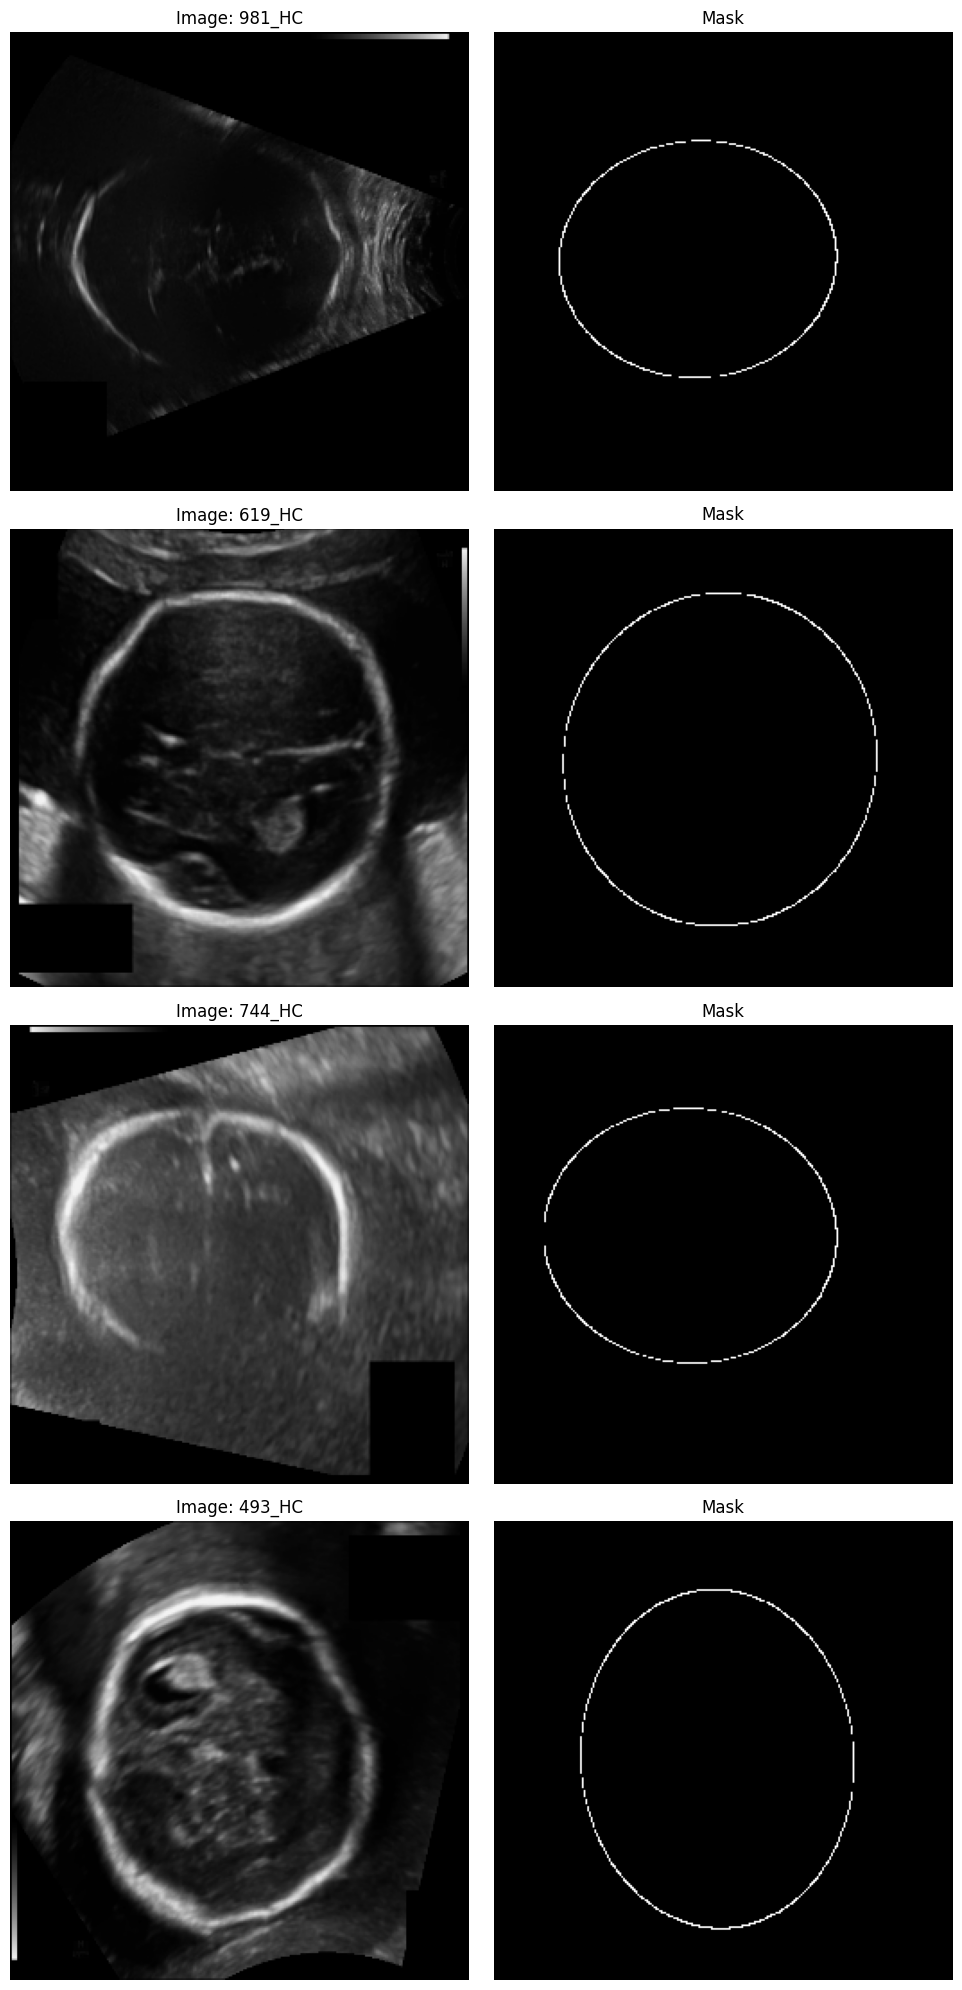

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from torch.utils.data import DataLoader
import albumentations as A
from dataset import Dataset
from glob import glob

def visualize_dataset(data_dir, dataset_name, img_ext, mask_ext, mask_suffix):
    """Universal visualization function for both datasets"""
    # Configure paths based on dataset
    if dataset_name == 'ISIC':
        img_dir = os.path.join(data_dir, 'ISIC-2017_Training_Data')
        mask_dir = os.path.join(data_dir, 'ISIC-2017_Training_Part1_GroundTruth')
    elif dataset_name == 'Fetus_Head':
        img_dir = os.path.join(data_dir, 'training_set')
        mask_dir = os.path.join(data_dir, 'training_set')
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    # Get matched image-mask pairs
    img_files = sorted([f for f in glob(os.path.join(img_dir, '*' + img_ext))
                       if not f.endswith(mask_ext)])
    img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_files]

    mask_files = sorted(glob(os.path.join(mask_dir, '*' + mask_ext)))
    mask_ids = [os.path.splitext(os.path.basename(p))[0].replace(mask_suffix, '') for p in mask_files]

    # Filter to ensure 1:1 mapping
    valid_pairs = [(i, m) for i, m in zip(img_ids, mask_ids)
                  if os.path.exists(os.path.join(mask_dir, f"{m}{mask_ext}"))]
    img_ids, mask_ids = zip(*valid_pairs) if valid_pairs else ([], [])

    print(f"Found {len(img_ids)} valid image-mask pairs")

    transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ])

    # Create dataset and loader
    dataset = Dataset(
        img_ids=list(img_ids),
        mask_ids=list(mask_ids),
        img_dir=img_dir,
        mask_dir=mask_dir,
        img_ext=img_ext,
        mask_ext=mask_ext,
        num_classes=1,
        transform=transform
    )

    data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

    # Visualize
    images, masks, metadatas = next(iter(data_loader))

    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    for i in range(4):
        image = images[i].numpy().transpose(1, 2, 0)
        mask = masks[i].numpy().transpose(1, 2, 0).squeeze()

        axes[i,0].imshow(image)
        axes[i,0].set_title(f'Image: {metadatas["img_id"][i]}')
        axes[i,0].axis('off')

        axes[i,1].imshow(mask, cmap='gray')
        axes[i,1].set_title('Mask')
        axes[i,1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for Fetus_Head:
visualize_dataset(
    data_dir='/content/drive/MyDrive/Datasets/Fetus_Head',
    dataset_name='Fetus_Head',
    img_ext='.png',
    mask_ext='_Annotation.png',
    mask_suffix='_Annotation'
)


In [ ]:
!ls /content/drive/MyDrive/Datasets/Fetus_Head/training_set | grep "260_HC"

260_HC(1).png
260_HC_Annotation.png
260_HC.png


In [ ]:
!ls /content/drive/MyDrive/Datasets/Fetus_Head/training_set | grep "721"

721_2HC(1).png
721_2HC_Annotation.png
721_2HC.png


In [ ]:
!rm "/content/drive/MyDrive/Datasets/Fetus_Head/training_set/721_2HC(1).png"

In [ ]:
from importlib import reload
import dataset  # Your module name
reload(dataset)
from dataset import Dataset

In [ ]:
# In Colab, check __init__ parameters
import inspect
from dataset import Dataset

print(inspect.signature(Dataset.__init__))
# Should show: (self, img_ids, mask_ids, img_dir, mask_dir, img_ext, mask_ext, num_classes, transform=None)


(self, img_ids, mask_ids, img_dir, mask_dir, img_ext, mask_ext, num_classes, transform=None)


In [ ]:
!python train.py --dataset Fetus_Head --data_dir '/content/drive/MyDrive/Datasets/Fetus_Head' --name fh_ukan --epochs 30 -b 8

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using device : cuda
--------------------
name: fin_fh_up
epochs: 30
batch_size: 8
dataseed: 2981
arch: UKAN
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 256
input_h: 256
input_list: [128, 160, 256]
loss: BCEDiceLoss
dataset: Fetus_Head
data_dir: /content/drive/MyDrive/Datasets/Fetus_Head
output_dir: /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
kan_lr: 0.01
kan_weight_decay: 0.0001
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
cfg: None
num_workers: 4
no_kan: False
--------------------
Training image paths: ['/content/drive

In [ ]:
import os

def count_files_and_folders(path):
    """Counts the number of files and folders in a given directory."""
    num_files = 0
    num_folders = 0

    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return 0,0

    for _, dirnames, filenames in os.walk(path):
        #print(dirnames)
        #print(filenames)
        num_files += len(filenames)
        num_folders += len(dirnames)
    return num_files, num_folders

# Example usage (use your actual paths):
training_path = "/content/drive/MyDrive/Datasets/Fetus_Head/training_set"
validation_path = "/content/drive/MyDrive/Datasets/Fetus_Head/validation_set"

num_train_files, num_train_folders = count_files_and_folders(training_path)
print(f"Training set: Files={num_train_files}, Folders={num_train_folders}")

num_val_files, num_val_folders = count_files_and_folders(validation_path)
print(f"Validation set: Files={num_val_files}, Folders={num_val_folders}")

Training set: Files=1601, Folders=0
Validation set: Files=400, Folders=0


In [ ]:
cd ..

/content/drive/MyDrive/Codes_ADL_Assignment


In [ ]:
!zip -r Seg_UKAN_TwoDatasets.zip Seg_UKAN

  adding: Seg_UKAN/ (stored 0%)
  adding: Seg_UKAN/utils.py (deflated 54%)
  adding: Seg_UKAN/losses.py (deflated 59%)
  adding: Seg_UKAN/environment.yml (deflated 47%)
  adding: Seg_UKAN/requirements.txt (deflated 32%)
  adding: Seg_UKAN/LICENSE (deflated 41%)
  adding: Seg_UKAN/kan.py (deflated 77%)
  adding: Seg_UKAN/scripts.sh (deflated 77%)
  adding: Seg_UKAN/val.py (deflated 65%)
  adding: Seg_UKAN/metrics.py (deflated 71%)
  adding: Seg_UKAN/config.py (deflated 66%)
  adding: Seg_UKAN/__pycache__/ (stored 0%)
  adding: Seg_UKAN/__pycache__/utils.cpython-311.pyc (deflated 48%)
  adding: Seg_UKAN/__pycache__/kan.cpython-311.pyc (deflated 56%)
  adding: Seg_UKAN/__pycache__/losses.cpython-311.pyc (deflated 49%)
  adding: Seg_UKAN/__pycache__/metrics.cpython-311.pyc (deflated 55%)
  adding: Seg_UKAN/__pycache__/archs.cpython-311.pyc (deflated 68%)
  adding: Seg_UKAN/__pycache__/dataset.cpython-311.pyc (deflated 50%)
  adding: Seg_UKAN/archs.py (deflated 82%)
  adding: Seg_UKAN/outpu

In [ ]:
from google.colab import files
files.download("Seg_UKAN_TwoDatasets.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Lumbar Spine

In [ ]:
cd /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/

/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
cd /content/drive/MyDrive/SharedFilesHere/Codes_ADL_Assignment/Seg_UKAN/

/content/drive/.shortcut-targets-by-id/1VC9diVivyUMD1TPsJuRquq3o6UCWWmiv/Codes_ADL_Assignment/Seg_UKAN


In [ ]:
!pip install medpy
!pip install tensorboardX
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 23.1 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224709 sha256=713899acda47784e3d6290733dee94da0484d685292991b69cd57dcc9b1a1f1f
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Number of images for visualization: 717
Number of masks for visualization: 717
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


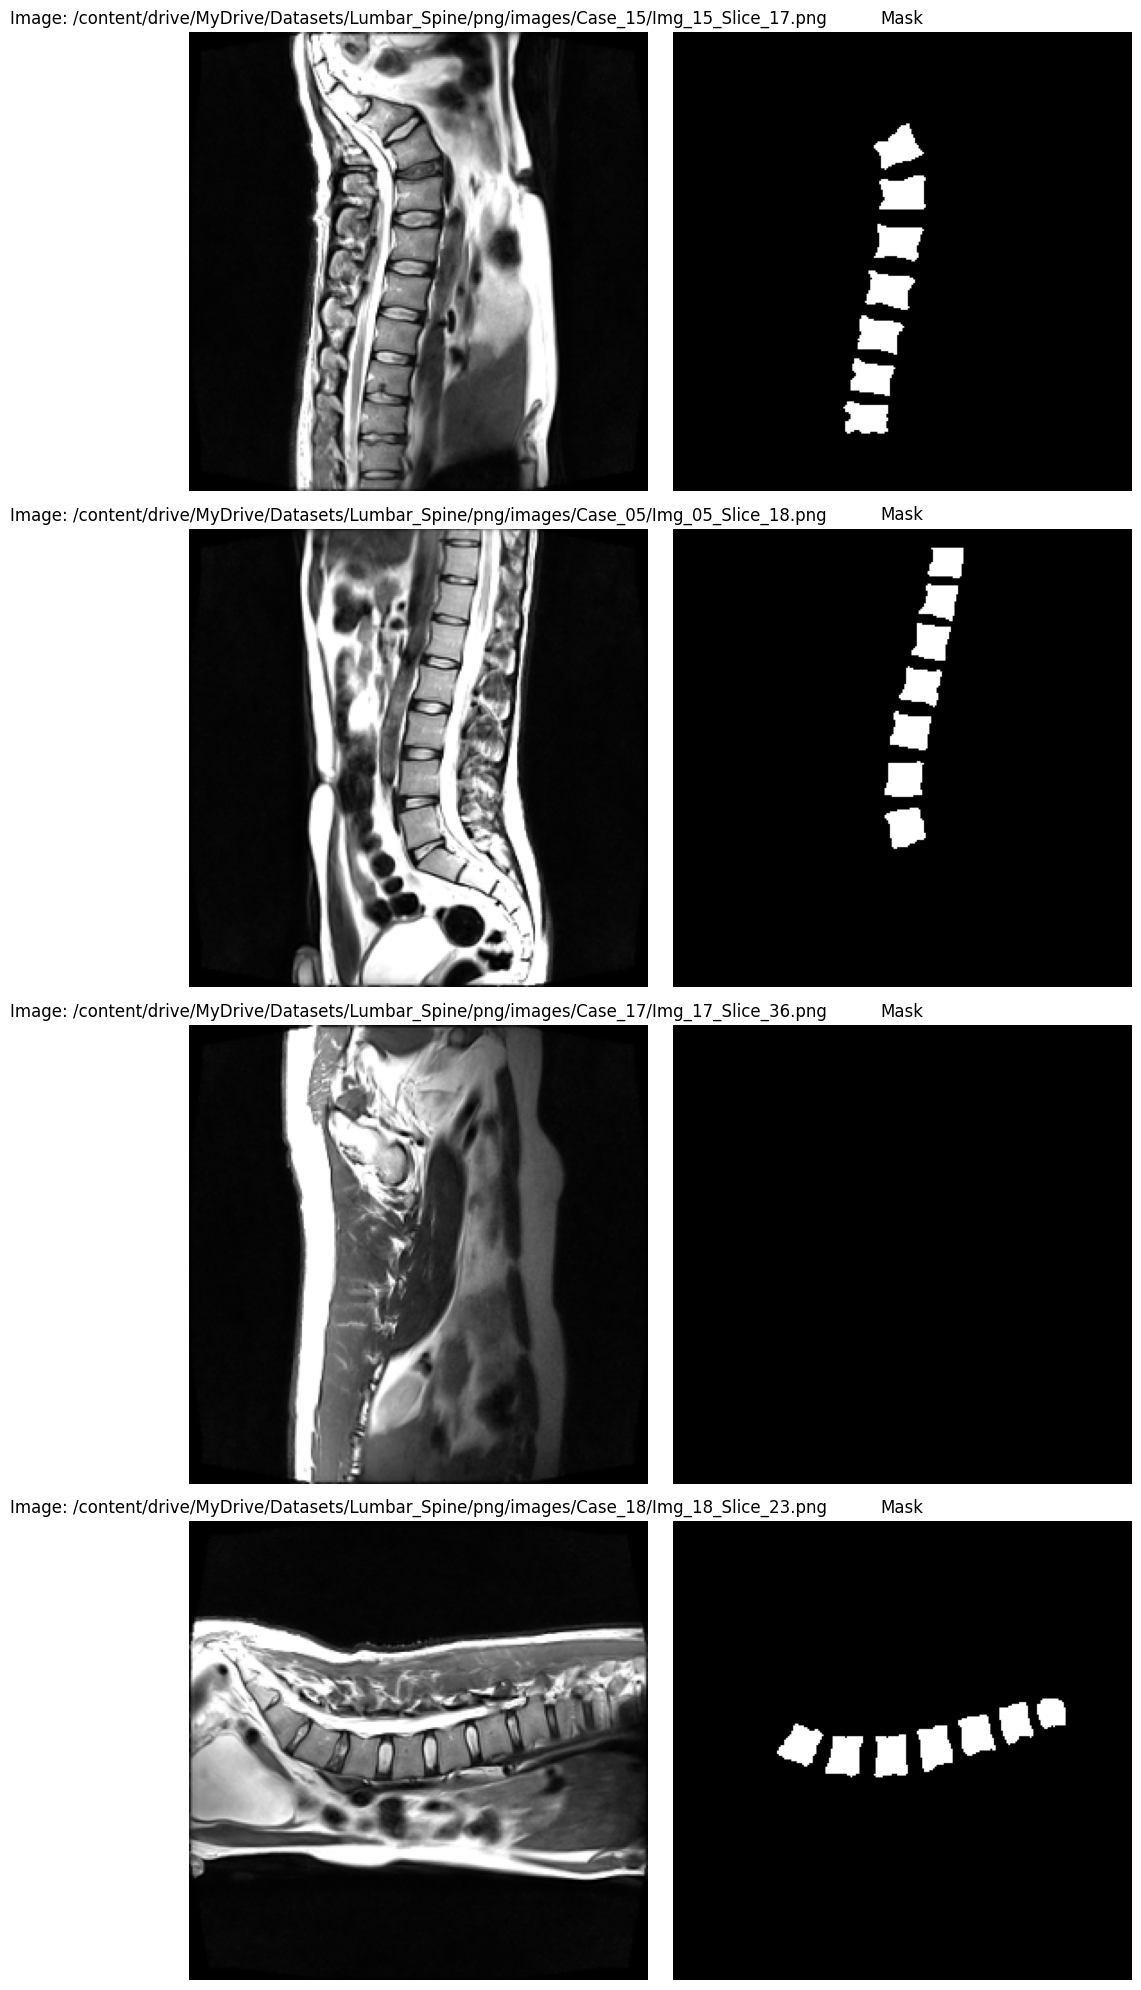

In [ ]:
# visualize_lumbar_spine.py
import os
import numpy as np
import torch
import albumentations as A
from torch.utils.data import DataLoader
from lumbarSpineDataset import LumbarSpineDataset  # Import your dataset class
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

def visualize_lumbar_spine(data_dir, batch_size=4, num_workers=0, train_split = 0.8, seed=42):
    """Visualizes images and masks from the Lumbar Spine dataset."""

    img_ext = '.png'
    mask_ext = '.png'  # Masks are also PNGs in this dataset
    base_dir = os.path.join(data_dir, 'png')

    # Create lists to store image and mask paths
    img_paths = []
    mask_paths = []

    # Iterate through 'images' and 'masks' subdirectories
    for split in ['images', 'masks']:
        split_dir = os.path.join(base_dir, split)
        for case_folder in sorted(os.listdir(split_dir)):
            case_path = os.path.join(split_dir, case_folder)
            if os.path.isdir(case_path):  # Ensure it's a directory
                for file in sorted(glob(os.path.join(case_path, '*' + img_ext))):
                    if split == 'images':
                        img_paths.append(file) #Full path
                    elif split == 'masks':
                        mask_paths.append(file) # Full path

    # Split paths into training and validation (80/20 split)
    train_img_ids, val_img_ids, train_mask_ids, val_mask_ids = train_test_split(
        img_paths, mask_paths, test_size=1-train_split, random_state=seed
    )
    # Use training set for visualization (you can change this to val_img_ids, val_mask_ids)
    img_ids = train_img_ids
    mask_ids = train_mask_ids
    img_dir = ""
    mask_dir = "" # We don't need img_dir and mask_dir anymore as img_ids have full path

    print(f"Number of images for visualization: {len(img_ids)}")
    print(f"Number of masks for visualization: {len(mask_ids)}")


    transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # Add any other augmentations you want to visualize
    ])

    dataset = LumbarSpineDataset(img_ids, mask_ids, img_dir, mask_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    images, masks, metadatas = next(iter(data_loader))

    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    # print("Metadata:", metadatas) # Metadata now contains full paths.

    # Display images and masks
    num_samples = images.shape[0]
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        image = images[i].numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
        mask = masks[i].numpy().transpose(1, 2, 0)   # Convert to (H, W, C)
        mask = np.squeeze(mask, axis=2)             # Remove channel dimension: (H, W, 1) -> (H, W)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'Image: {metadatas["img_id"][i]}')  # Show image ID
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()



if __name__ == '__main__':
    # Example Usage (adjust data_dir as needed)
    data_dir = '/content/drive/MyDrive/Datasets/Lumbar_Spine'  # Or your Kaggle path
    visualize_lumbar_spine(data_dir) # You can put train split and random seed here.

In [42]:
!python train.py --dataset Lumbar_Spine --data_dir '/content/drive/MyDrive/Datasets/Lumbar_Spine/' --name ls_ukan_upgraded --epochs 30 -b 8 --upgrade

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO: Using UPGRADED architectures from archs_upgraded.py
Using device : cuda
--------------------
name: ls_ukan_upgraded
epochs: 30
batch_size: 8
dataseed: 2981
arch: UKAN
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 256
input_h: 256
input_list: [128, 160, 256]
upgrade: True
loss: BCEDiceLoss
dataset: Lumbar_Spine
data_dir: /content/drive/MyDrive/Datasets/Lumbar_Spine/
output_dir: /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
kan_lr: 0.01
kan_weight_decay: 0.0001
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
cfg: None
num_

In [55]:
!python train.py --dataset Lumbar_Spine --data_dir '/content/drive/MyDrive/Datasets/Lumbar_Spine/' --name NANANOUP --epochs 30 -b 8

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO: Using standard architectures from archs.py
Using device : cuda
--------------------
name: NANANOUP
epochs: 30
batch_size: 8
dataseed: 2981
arch: UKAN
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 256
input_h: 256
input_list: [128, 160, 256]
upgrade: False
loss: BCEDiceLoss
dataset: Lumbar_Spine
data_dir: /content/drive/MyDrive/Datasets/Lumbar_Spine/
output_dir: /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
kan_lr: 0.01
kan_weight_decay: 0.0001
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
cfg: None
num_workers: 4
no_ka

In [ ]:
import os
import glob
import random

def find_viz_image_path(data_dir, dataset_name, sample_idx=7, random_seed=None):
    """
    Finds the path of the visualization image and mask for specified datasets,
    replicating the train/val split logic for Lumbar Spine.

    Args:
        data_dir: The path to the base dataset directory.
        dataset_name: String, 'ISIC', 'Fetus_Head', or 'Lumbar_Spine'.
        sample_idx: The index of the sample image from the training set portion.
        random_seed: The seed used for the train/val split in Lumbar Spine.
                     MUST match the seed used in train.py (e.g., config['dataseed']).
                     If None for Lumbar Spine, the split cannot be replicated.

    Returns:
        A tuple: (image_path, mask_path) or (None, None) if not found or unsupported dataset.
    """
    img_paths_train = []  # Will store the final training paths in the correct order
    mask_paths_train = [] # Will store the final training paths in the correct order

    if dataset_name == 'ISIC':
        img_ext = '.jpg'
        mask_ext = '_segmentation.png'
        train_img_dir = os.path.join(data_dir, 'ISIC-2017_Training_Data')
        train_mask_dir = os.path.join(data_dir, 'ISIC-2017_Training_Part1_GroundTruth')

        if not os.path.exists(train_img_dir):
            print(f"ISIC Image directory not found: {train_img_dir}")
            return None, None
        if not os.path.exists(train_mask_dir):
            print(f"ISIC Mask directory not found: {train_mask_dir}")
            return None, None

        all_img_files = sorted(glob.glob(os.path.join(train_img_dir, '*' + img_ext)))
        all_mask_files = sorted(glob.glob(os.path.join(train_mask_dir, '*' + mask_ext)))
        img_id_to_path = {os.path.splitext(os.path.basename(p))[0]: p for p in all_img_files}

        # Match masks to images - these become the potential training pool
        temp_img_list = []
        temp_mask_list = []
        for mask_file in all_mask_files:
            mask_base_id = os.path.splitext(os.path.basename(mask_file))[0].replace('_segmentation', '')
            if mask_base_id in img_id_to_path:
                temp_img_list.append(img_id_to_path[mask_base_id])
                temp_mask_list.append(mask_file)

        # For ISIC, the 'training set' IS the set of matched pairs, no random split needed here
        img_paths_train = temp_img_list
        mask_paths_train = temp_mask_list


    elif dataset_name == 'Fetus_Head':
        img_ext = '.png'
        mask_ext = '_Annotation.png'
        train_dir = os.path.join(data_dir, 'training_set')

        if not os.path.exists(train_dir):
            print(f"Fetus Head training directory not found: {train_dir}")
            return None, None

        all_files = sorted(glob.glob(os.path.join(train_dir, '*' + img_ext)))
        img_id_to_path = {}
        temp_img_list = []
        temp_mask_list = []

        for file_path in all_files:
            if not file_path.endswith(mask_ext):
                img_base_id = os.path.splitext(os.path.basename(file_path))[0]
                img_id_to_path[img_base_id] = file_path

        for file_path in all_files:
            if file_path.endswith(mask_ext):
                mask_base_id = os.path.splitext(os.path.basename(file_path))[0].replace('_Annotation', '')
                if mask_base_id in img_id_to_path:
                    temp_img_list.append(img_id_to_path[mask_base_id])
                    temp_mask_list.append(file_path)

        # For Fetus Head, the 'training set' IS the set of matched pairs
        img_paths_train = temp_img_list
        mask_paths_train = temp_mask_list

    elif dataset_name == 'Lumbar_Spine':
        if random_seed is None:
            print("ERROR: random_seed must be provided for Lumbar Spine to replicate train/val split.")
            return None, None

        print(f"Replicating Lumbar Spine 80/20 split with seed: {random_seed}")
        random.seed(random_seed) # Set the seed *before* the loop

        img_ext = '.png'
        base_dir = os.path.join(data_dir, 'png')
        image_base_dir = os.path.join(base_dir, 'images')
        mask_base_dir = os.path.join(base_dir, 'masks')

        if not os.path.exists(image_base_dir) or not os.path.exists(mask_base_dir):
            print(f"Lumbar Spine directories not found.")
            return None, None

        # Iterate exactly like train.py to build the list in the same order
        # and apply the random split condition iteratively
        case_folders = sorted(os.listdir(image_base_dir))
        for case_folder in case_folders:
            case_path_img = os.path.join(image_base_dir, case_folder)
            case_path_mask = os.path.join(mask_base_dir, case_folder)

            if os.path.isdir(case_path_img) and os.path.isdir(case_path_mask):
                image_files = sorted(glob.glob(os.path.join(case_path_img, '*' + img_ext)))

                for img_file in image_files:
                    img_filename = os.path.basename(img_file)
                    mask_filename = img_filename.replace('Slice', 'Labels_Slice')
                    mask_path = os.path.join(case_path_mask, mask_filename)

                    if os.path.exists(mask_path):
                        # Apply the random split condition *here* for each pair
                        if random.random() < 0.8:
                            img_paths_train.append(img_file)
                            mask_paths_train.append(mask_path)
                        # else: # This pair goes to validation (we don't store it here)
                        #    pass

    else:
        print(f"Unsupported dataset for visualization: {dataset_name}")
        return None, None

    # --- Final check and return based on the derived training lists ---
    if not img_paths_train: # Check if the training list ended up empty
        print(f"The derived training list for {dataset_name} is empty.")
        return None, None

    if sample_idx < len(img_paths_train):
        image_path = img_paths_train[sample_idx]
        # Need to ensure mask list is also long enough (should be if logic is correct)
        if sample_idx < len(mask_paths_train):
             mask_path = mask_paths_train[sample_idx]
             return image_path, mask_path
        else:
             print(f"Mismatch between train image ({len(img_paths_train)}) and mask ({len(mask_paths_train)}) list lengths.")
             return img_paths_train[sample_idx], None # Return image path but indicate mask issue
    else:
        print(f"Sample index {sample_idx} is out of range for the derived training list of dataset {dataset_name} (list length: {len(img_paths_train)}).")
        return None, None


# --- Example Usage ---

# Get the random seed used in train.py (MAKE SURE THIS IS CORRECT)
train_py_seed = 2981 # Example: Use the value from config['dataseed']

# --- For ISIC ---
isic_data_directory = "/content/drive/MyDrive/Datasets/ISIC/"
isic_sample_idx = 2
isic_image_path, isic_mask_path = find_viz_image_path(
    isic_data_directory,
    'ISIC',
    sample_idx=isic_sample_idx
    # No seed needed as no random split happens here
)
if isic_image_path:
    print("\n--- ISIC ---")
    print(f"Sample Index: {isic_sample_idx}")
    print(f"Visualization Image Path: {isic_image_path}")
    print(f"Visualization Mask Path: {isic_mask_path}")

# --- For Fetus Head ---
fetus_data_directory = "/content/drive/MyDrive/Datasets/Fetus_Head"
fetus_sample_idx = 2
fetus_image_path, fetus_mask_path = find_viz_image_path(
    fetus_data_directory,
    'Fetus_Head',
    sample_idx=fetus_sample_idx
    # No seed needed
)
if fetus_image_path:
    print("\n--- Fetus Head ---")
    print(f"Sample Index: {fetus_sample_idx}")
    print(f"Visualization Image Path: {fetus_image_path}")
    print(f"Visualization Mask Path: {fetus_mask_path}")

# --- For Lumbar Spine ---
lumbar_data_directory = "/content/drive/MyDrive/Datasets/Lumbar_Spine/"
lumbar_sample_idx = 7
lumbar_image_path, lumbar_mask_path = find_viz_image_path(
    lumbar_data_directory,
    'Lumbar_Spine',
    sample_idx=lumbar_sample_idx,
    random_seed=train_py_seed # Pass the seed used in train.py
)
if lumbar_image_path:
    print("\n--- Lumbar Spine ---")
    print(f"Sample Index (within training split): {lumbar_sample_idx}")
    print(f"Random Seed Used for Split: {train_py_seed}")
    print(f"Visualization Image Path: {lumbar_image_path}")
    print(f"Visualization Mask Path: {lumbar_mask_path}")


--- ISIC ---
Sample Index: 2
Visualization Image Path: /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg
Visualization Mask Path: /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000002_segmentation.png

--- Fetus Head ---
Sample Index: 2
Visualization Image Path: /content/drive/MyDrive/Datasets/Fetus_Head/training_set/102_2HC.png
Visualization Mask Path: /content/drive/MyDrive/Datasets/Fetus_Head/training_set/102_2HC_Annotation.png
Replicating Lumbar Spine 80/20 split with seed: 2981

--- Lumbar Spine ---
Sample Index (within training split): 7
Random Seed Used for Split: 2981
Visualization Image Path: /content/drive/MyDrive/Datasets/Lumbar_Spine/png/images/Case_01/Img_01_Slice_16.png
Visualization Mask Path: /content/drive/MyDrive/Datasets/Lumbar_Spine/png/masks/Case_01/Img_01_Labels_Slice_16.png


print(f"Visualization Image Path: {isic_image_path}")
    print(f"Visualization Mask Path: {isic_mask_path}")
    # You would now pass these paths to your modified predict_single_image.py
    # !python predict_single_image.py --model_path ... --image_path "{isic_image_path}" --mask_path "{isic_mask_path}" ...

In [ ]:
!python train.py --dataset Lumbar_Spine --data_dir '/content/drive/MyDrive/Datasets/Lumbar_Spine'

python3: can't open file '/content/train.py': [Errno 2] No such file or directory


### Evaluation

In [25]:
cd /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/

/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN


In [57]:
!python evaluate.py \
    --model_path '/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs/fin_is/model.pth' \
    --data_dir '/content/drive/MyDrive/Datasets/ISIC/' \
    --dataset ISIC \
    --arch UKAN \
    --input_channels 3 \
    --input_h 256 \
    --input_w 256

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO: Using standard architectures from archs.py for evaluation
Loading evaluation data for dataset: ISIC
Data base directory: /content/drive/MyDrive/Datasets/ISIC/
Expecting ISIC test images in: /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Test_v2_Data
Expecting ISIC test masks in: /content/drive/MyDrive/Datasets/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth
Found 600 potential test images, 600 masks.
Using 600 images with corresponding masks for evaluation.
Creating model 'UKAN' with 3 input channels...
Loading model weights from: /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs/fin_is/model.pth
Model weights loaded successfully.
Evaluating: 100% 75/75 [12:13<00:00,  9.78s/it, IoU=0.7385, Dice=0.8301]

Ev

In [52]:
!python evaluate.py \
    --model_path '/content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs/fin_ls_drug/model.pth' \
    --data_dir '/content/drive/MyDrive/Datasets/Lumbar_Spine/' \
    --dataset Lumbar_Spine \
    --arch UKAN \
    --upgrade \
    --input_channels 3 \
    --input_h 256 \
    --input_w 256

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO: Using UPGRADED architectures from archs_upgraded.py for evaluation
Loading evaluation data for dataset: Lumbar_Spine
Data base directory: /content/drive/MyDrive/Datasets/Lumbar_Spine/
Expecting Lumbar images in: /content/drive/MyDrive/Datasets/Lumbar_Spine/png/images
Expecting Lumbar masks in: /content/drive/MyDrive/Datasets/Lumbar_Spine/png/masks
Creating model 'UKAN' with 3 input channels...
Loading model weights from: /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN/outputs/fin_ls_drug/model.pth
Model weights loaded successfully.
Evaluating: 100% 113/113 [00:40<00:00,  2.82it/s, IoU=0.6077, Dice=0.6652]

Evaluation Results for Lumbar_Spine using model /content/drive/MyDrive/Codes_ADL_Assignment/Seg_UKAN

In [ ]:
ls

archs.py         evaluate.py            metrics.py               __pycache__/      val.py
BestModels/      kan.py                 moveValidationFetus.sh   requirements.txt
config.py        LICENSE                noTrain.py               scripts.sh
dataset.py       losses.py              outputs/                 train.py
environment.yml  lumbarSpineDataset.py  predict_single_image.py  utils.py
